<a href="https://colab.research.google.com/github/DanielEXT10/AI/blob/main/Temp_forecasting_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 3: RNN y sus aplicaciones en las series temporales

En esta actividad se va a aplicar el conocimiento adquirido sobre las RNN para entrenar modelos que sean capaces de predecir el comportamiento de las series temporales. Para ello, se usará un dataset de temperaturas para mediante la aplicación de RNN, predecir los valores futuros que tendrá la serie temporal que se tiene. Este trabajo se suele hacer mediante modelos ARIMA, pero en esta práctica se verá cómo el modelado mediante RNN es una opción muy buena en estos casos de series temporales.

**1. Descargar el dataset y almacenarlo**

En primer lugar hay que importar tensorflow.

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)

Found GPU at: /device:GPU:0
2.12.0


In [4]:
import pandas as pd

El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [6]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2023-08-31 12:32:39--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2023-08-31 12:32:39 (52.9 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

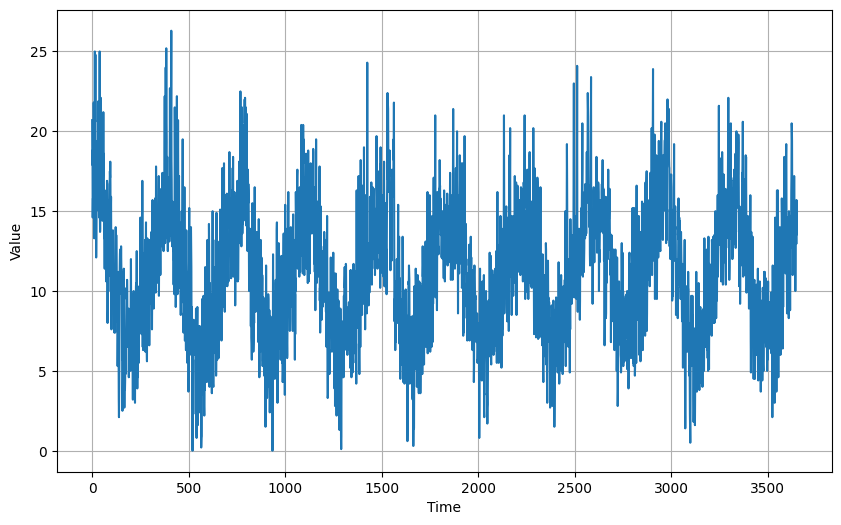

In [7]:

import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
data_dict = {'time':time, 'Value':series}
temp_df = pd.DataFrame(data_dict)

In [12]:
temp_df

,time,Value
0,0,20.7
1,1,17.9
2,2,18.8
3,3,14.6
4,4,15.8
...,...,...
3645,3645,14.0
3646,3646,13.6
3647,3647,13.5
3648,3648,15.7


# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

**Ejercicio 1 (0.4 puntos)**: Crear las variables de entrenamiento y validación y hacer la partición de las mismas. Las variables que hay que crear son:

*   time_train
*   x_train
*   time_valid
*   x_valid





In [13]:
temp_df

,time,Value
0,0,20.7
1,1,17.9
2,2,18.8
3,3,14.6
4,4,15.8
...,...,...
3645,3645,14.0
3646,3646,13.6
3647,3647,13.5
3648,3648,15.7


In [37]:
## variables para la técnica de la ventana temporal
split_time = 2921
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Split del dataset en entrenamiento y validación

time = temp_df['time']
temp = temp_df['Value']

train_index = int(len(time)*0.8)
time_train = time[:train_index]
x_train = temp[:train_index]

time_valid = time[train_index+1:]
x_valid = temp[train_index+1:]

## tu código para la creación de las 4 variables del ejercicio 1 aquí

In [36]:
time_valid

2921    2921
2922    2922
2923    2923
2924    2924
2925    2925
        ... 
3645    3645
3646    3646
3647    3647
3648    3648
3649    3649
Name: time, Length: 729, dtype: int64

2. Creación del método **windowed_datset** para poder utilizarlo en el modelo. Las entradas por parámetros del método son:

*   series
*   window_size
*   batch_size
*   shuffle_buffer

El resto de elementos que se usan para construir la función ventana temporal para explorar el dataset, son métodos de Python para tratar con series temporales.




# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

**Ejercicio 2 (1.6 puntos)**: completar el método model_forecast creando los elementos necesarios dentro del método:

1.   Crear la variable **ds** y darle el valor resultante del método **from_tensor_slices** pasando por parametro **series** **(0.4 puntos)**
2.   Actualizar la ventana (**window**) de la variable **ds** (nota: en este caso el tamaño es el mismo de la ventana, no es necesario que sea window_size+1) **(0.4 puntos)**
3.   Crear el **flat_map** de la variable, teniendo en cuenta que el tamaño es **window_size** **(0.4 puntos)**
4.   Añadir la siguiente linea de código: ds = ds.batch(32).prefetch(1)
5.   Crear la variable **forecast** en la que se usará el método **predict** **(0.4 puntos)**
6.   Por último, se devolverá la variable forecast.




In [16]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)

    # Create the initial dataset
    ds = tf.data.Dataset.from_tensor_slices(series)

    # Window the dataset
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    # Batch and prefetch the dataset
    ds = ds.batch(32).prefetch(1)

    forecast = model.predict(ds)

    return forecast


## tu código para el método model_forecast del ejercicio 2 a


A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

# 4. Diseño de la red neuronal

**Ejercicio 3.1 (0.5 puntos)**: Hay que crear la variable **train_set** dandole el valor que se reciba del método **windowed_datset**, los parametros que debe recibir este método son: **x_train, window_size, batch_size, shuffle_buffer_size**

In [18]:
## tu código aquí para el ejercicio 3
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [20]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

**Ejercicio 3.2 (4 puntos)**: Se debe construir la red neuronal de aprendizaje profunda basada para modelar la serie temporal de las temperaturas minimas diarias. Esta red neuronal debera contar con las siguientes capas ocultas:

1.   Una capa de convolución en una dimensión que tenga 32 filtros, una tamaño del kernel de 5, un stride de 1, padding "causal", la función de activación debe ser relu y el input shape debe ser [None, 1]
2.   Una capa LSTM con 64 neuronas y retorno de secuencias
3.   Una capa LSTM con 64 neuronas y retorno de secuencias
4.   Una capa densa con 30 neuronas
5.   Una capa densa con 10 neuronas
6.   Una capa densa con 1 neuronas
7.   Por último, se añade la siguiente capa: tf.keras.layers.Lambda(lambda x: x * 400)




In [21]:
## tu código para la red neuronal del ejercicio 4 aquí
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda

# Definir la arquitectura de la red neuronal
model = Sequential([
    Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=(None, 1)),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
    Lambda(lambda x: x * 400)
])



# 5. Entrenamiento de la red neuronal

**Ejercicio 4 (0.5 puntos)**: Se va a diseñar un método callbacks para el learning rate que será guardado en la variable **lr_schedule**, este método deberá usar el método **LearningRateScheduler** de Python y será una función **lambda** que le de el valor a epoch de 1e-8 * 10 **(epoch / 20)

In [22]:
## tu código para crear la variable lr_schedule aquí

from tensorflow.keras.callbacks import LearningRateScheduler
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 *10 **(epoch/20))

**Ejercicio 5 (1.5 puntos):** Compilar la red neuronal con los siguientes parametros:

*   loss: método Huber de keras
*   El optimizador debe ser el SGD con learning rate 1e-8 y momentum 0.9
*   La métrica a visualizar es el error absoluto medio (medium absolute error en ingles)



In [23]:
## tu código para compilar la red neuronal para el ejercicio 5 aquí
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError

optimizer =SGD(learning_rate=1e-8, momentum=0.9)
model.compile(optimizer=optimizer, loss=Huber(), metrics=[MeanAbsoluteError()])

Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [24]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 17s 107ms/step - loss: 12.5449 - mean_absolute_error: 13.0377 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 53ms/step - loss: 12.0749 - mean_absolute_error: 12.5678 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 45ms/step - loss: 11.4857 - mean_absolute_error: 11.9773 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 47ms/step - loss: 10.9455 - mean_absolute_error: 11.4371 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 47ms/step - loss: 10.5115 - mean_absolute_error: 11.0032 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 45ms/step - loss: 10.1758 - mean_absolute_error: 10.6670 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 44ms/step - loss: 9.9064 - mean_absolute_error: 10.3984 - lr: 1.9953e-08
Epoch 8/100
12/12 [==============================] - 1s 46ms/step - loss: 9.6902 - mean_a

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

(1e-08, 0.0001, 0.0, 60.0)

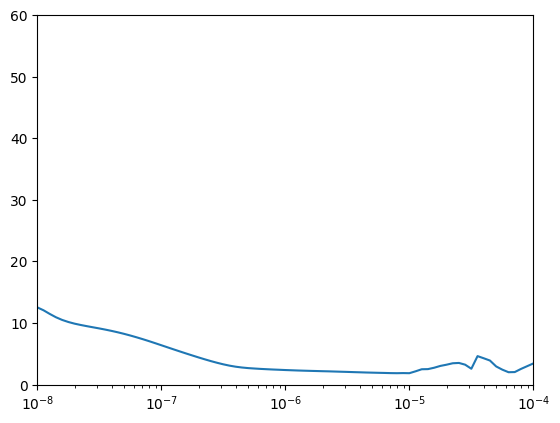

In [25]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

**Ejercicio 6 (0.5 puntos)**: Para crear el nuevo modelo, reutiliza la red neuronal diseñada en el ejercicio 4, pero esta vez utilizando 60 filtros en la capa de convolución.

In [27]:
## tu código para la red neuronal del ejercicio 6 aquí
model = Sequential([
    Conv1D(filters=60, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=(None, 1)),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
    Lambda(lambda x: x * 400)
])


**Ejercicio 7 (0.5 puntos)**: Se debe volver a compilar la red neuronal de manera análoga a la del ejercicio 5, pero esta vez utilizar un learning rate obtenido de la función callback.

In [28]:
## tu código para compilar la red neuronal para el ejercicio 7 aquí
optimizer =SGD(learning_rate=1e-05, momentum=0.9)
model.compile(optimizer=optimizer, loss=Huber(), metrics=[MeanAbsoluteError()])

In [29]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
29/29 [==============================] - 5s 24ms/step - loss: 15.1706 - mean_absolute_error: 15.6436
Epoch 2/150
29/29 [==============================] - 1s 26ms/step - loss: 1.9982 - mean_absolute_error: 2.4528
Epoch 3/150
29/29 [==============================] - 1s 25ms/step - loss: 1.8766 - mean_absolute_error: 2.3288
Epoch 4/150
29/29 [==============================] - 1s 26ms/step - loss: 1.8230 - mean_absolute_error: 2.2741
Epoch 5/150
29/29 [==============================] - 2s 46ms/step - loss: 1.7855 - mean_absolute_error: 2.2357
Epoch 6/150
29/29 [==============================] - 1s 26ms/step - loss: 1.7549 - mean_absolute_error: 2.2045
Epoch 7/150
29/29 [==============================] - 1s 26ms/step - loss: 1.7325 - mean_absolute_error: 2.1818
Epoch 8/150
29/29 [==============================] - 1s 24ms/step - loss: 1.7156 - mean_absolute_error: 2.1647
Epoch 9/150
29/29 [==============================] - 1s 27ms/step - loss: 1.7013 - mean_absolute_error: 2.1502

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [38]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

114/114 [==============================] - 1s 9ms/step


In [39]:
len(rnn_forecast)

729

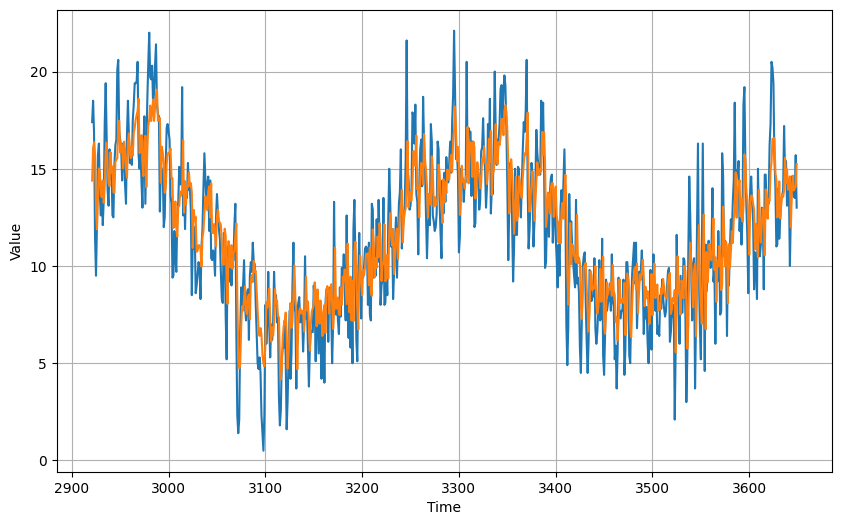

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7506907

In [42]:
print(rnn_forecast)

[14.392795  16.055082  16.361343  15.709579  13.055616  11.880144
 13.649279  15.020352  14.829991  13.654235  13.537651  14.4000025
 13.248357  14.077434  15.908601  16.343037  15.075481  14.25226
 14.110355  15.853864  14.806859  15.112344  13.797183  13.751303
 15.346996  15.462679  15.552545  17.299858  17.467937  15.833876
 16.297066  16.126179  15.027243  16.396172  15.942796  14.996542
 14.541873  16.384865  16.822216  15.824178  15.547523  16.158955
 15.673956  16.85493   17.110014  17.539017  17.759787  17.975529
 18.598236  15.803859  15.893501  16.729643  15.316335  14.620143
 16.414217  16.699686  14.049859  15.963495  17.210451  17.519178
 18.251307  17.45626   17.940739  18.563246  17.457952  18.134378
 18.822664  19.06977   17.472012  17.583805  17.613308  14.277348
 16.136438  15.825704  15.316765  13.762683  13.997936  15.210505
 15.793626  15.760618  15.847419  16.043701  14.513451  14.511379
 11.955393  12.008706  13.315511  11.99408   11.521317  13.072379
 13.086958

# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [43]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

A continuación se realiza el plot de la pérdida frente a los epochs

<Figure size 640x480 with 0 Axes>

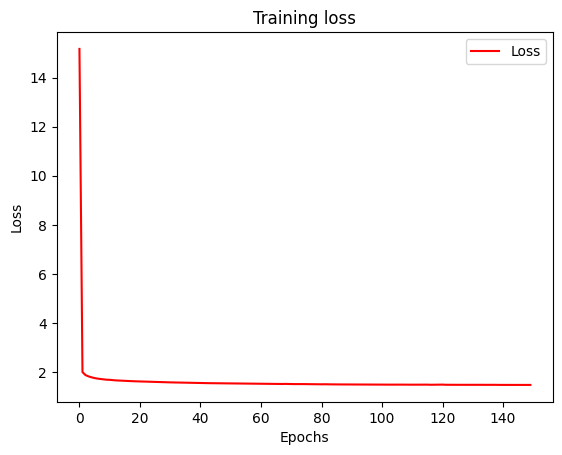

<Figure size 640x480 with 0 Axes>

In [44]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

**Ejercicio 8 (0.5 punto)**: Utilizando las 2 nuevas variables zoomed_loss y zoomed_epochs y con base en el código anterior, hacer el plot del loss frente a los epochs entre los epoch 20 y 150 para ver como va oscilando y no es un proceso lineal como podria parecer según el anterior plot.

In [45]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
zoomed_loss = loss[20:]
zoomed_epochs = range(20,150)
#
## tu código para el plot con zoom del ejercicio 8 aquí